# Version 3: Imputing Missing Values

In my previous two models, I limited myself to featuers that had comprehensive representation through both test and training sets--no missing values, in other words. That meant isolating the following features: `Pclass`, `Sex`, `SipSp` (number of siblings or spouses aboard), and `Parch` (number of parents or children aboard). My intuition is that other features, such as `age`, may also correlate with survival rate, however there are missing values for these. In this notebook, then, I want to experiment with imputing values where values are missing in order to see if that will boost model performance.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Imputing Missing Values
First, I want to remind myself what the limitations are in terms of missing values. If too many values are missing, I'm going to consider imputation implausible.

In [2]:
train_nulls = pd.DataFrame({
    'Null Values (Count)':train.isna().sum(), 
    'Null Values (Percentage)': train.isna().sum() / len(train)
})

test_nulls = pd.DataFrame({
    'Null Values (Count)':test.isna().sum(), 
    'Null Values (Percentage)': test.isna().sum() / len(test)
})


print("TRAINING SET")
print(train_nulls)
print()
print("TEST SET")
print(test_nulls)

TRAINING SET
             Null Values (Count)  Null Values (Percentage)
PassengerId                    0                  0.000000
Survived                       0                  0.000000
Pclass                         0                  0.000000
Name                           0                  0.000000
Sex                            0                  0.000000
Age                          177                  0.198653
SibSp                          0                  0.000000
Parch                          0                  0.000000
Ticket                         0                  0.000000
Fare                           0                  0.000000
Cabin                        687                  0.771044
Embarked                       2                  0.002245

TEST SET
             Null Values (Count)  Null Values (Percentage)
PassengerId                    0                  0.000000
Pclass                         0                  0.000000
Name                           0 

Looking at these numbers, my sense is to ignore `Cabin`, which is missing so many values (~80%) that imputation seems unrealistic. Everything else, though, I think we should be able to deal with. I'm going to go through the dataset feature by feature, then, and work on preparing it and imputing values where necessary.

Eventually, I'll have to imput values for both training and test sets, of course, but I'm going to focus on the training set until I arrive at a model that's performing well.

In [3]:
# Create new feature and target dataframes to be used for training and cross val
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
y = train['Survived']
X = train[features].copy()
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


In [4]:
# Impute missing `Embarked` value using most frequent port of embarkation code
from sklearn.impute import SimpleImputer

imp_freq = SimpleImputer(strategy='most_frequent')
X['Embarked'] = imp_freq.fit_transform(X[['Embarked']])

X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


In [5]:
# One hot encode categorical features
X = pd.get_dummies(X, columns=['Embarked', 'Pclass', 'Sex'])
X

,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,22.0,1,0,7.2500,0,0,1,0,0,1,0,1
1,38.0,1,0,71.2833,1,0,0,1,0,0,1,0
2,26.0,0,0,7.9250,0,0,1,0,0,1,1,0
3,35.0,1,0,53.1000,0,0,1,1,0,0,1,0
4,35.0,0,0,8.0500,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,0,0,1,0,1,0,0,1
887,19.0,0,0,30.0000,0,0,1,1,0,0,1,0
888,NaN,1,2,23.4500,0,0,1,0,0,1,1,0
889,26.0,0,0,30.0000,1,0,0,1,0,0,0,1


In [6]:
# Impute missing `Age` values using iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp_iter = IterativeImputer(min_value=X['Age'].min(), max_value=X['Age'].max())

cols = X.columns
X = pd.DataFrame(imp_iter.fit_transform(X))
X.columns = cols
X

,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,22.000000,1.0,0.0,7.2500,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,38.000000,1.0,0.0,71.2833,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,26.000000,0.0,0.0,7.9250,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,35.000000,1.0,0.0,53.1000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,35.000000,0.0,0.0,8.0500,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.000000,0.0,0.0,13.0000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
887,19.000000,0.0,0.0,30.0000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
888,20.407866,1.0,2.0,23.4500,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
889,26.000000,0.0,0.0,30.0000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


At this point we no longer have any missing values. Let's see whether this increased number of features results in a better-performing model.

In [7]:
# Split dataframe into training and cross validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)

In [8]:
# Create function to assess accuracy of multiple models
from sklearn.metrics import accuracy_score

def get_score(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_val)
    acc_score= accuracy_score(y_val, y_predict)
    return acc_score

In [9]:
# Create several models and evaluate performance
from sklearn.ensemble import RandomForestClassifier

model_1 = RandomForestClassifier(random_state=1, max_depth=4, n_estimators=50)
model_2 = RandomForestClassifier(random_state=1, max_depth=4, n_estimators=150)
model_3 = RandomForestClassifier(random_state=1, max_depth=8)
model_4 = RandomForestClassifier(random_state=1, max_depth=16)
model_5 = RandomForestClassifier(random_state=1, max_depth=32)

models = [model_1, model_2, model_3, model_4, model_5]

for model in models:
    print(get_score(model, X_train, X_val, y_train, y_val))

0.7892376681614349
0.7847533632286996
0.7982062780269058
0.7892376681614349
0.7802690582959642


So far I'm not seeing substantial improvement here. My next instinct, then, is to try engineering some features to see whether that helps. To determine how to approach this, I'll do a little exploratory analysis.

## Exploratory Analysis

I'm going to return to the original, pre-imputed training set and create a few charts.

In [10]:
# Recast categorical dtypes
cat_cols = ['Pclass', 'Survived', 'Sex', 'Embarked']

train[cat_cols] = train[cat_cols].astype('category')
train.dtypes

PassengerId       int64
Survived       category
Pclass         category
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
dtype: object

### Age

First, let's take a closer look at the `Age` feature. It's interesting to note that, while survivors skewed slightly younger than non-survivors, the distinction isn't so stark as one might think:

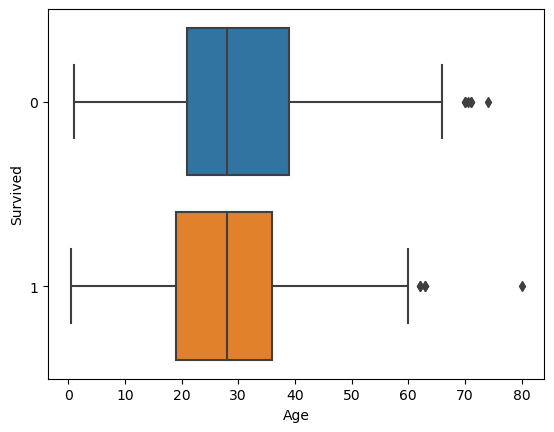

In [11]:
sns.boxplot(data=train, x='Age', y='Survived');

However, if we consider how age interacts with other features, we start to see bigger differences amongst survivors vs. non-survivors. For example, consider the port of embarkation:

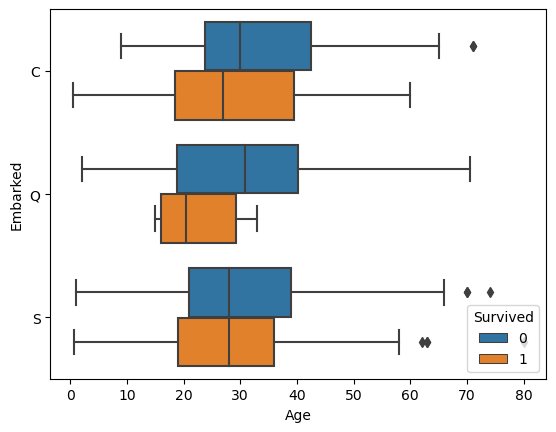

In [12]:
sns.boxplot(data=train, x='Age', y='Embarked', hue='Survived');

While I'm not certain why port of embarkation would correlate with survival rates, it's interesting to see that the age distributions of survivors vs. non-survivors diverge more noticably once we group the population by that port of embarkation.

We can see a similar divergence when grouped by sex: Male survivors skew younger than male victims, and vice-versa for women.

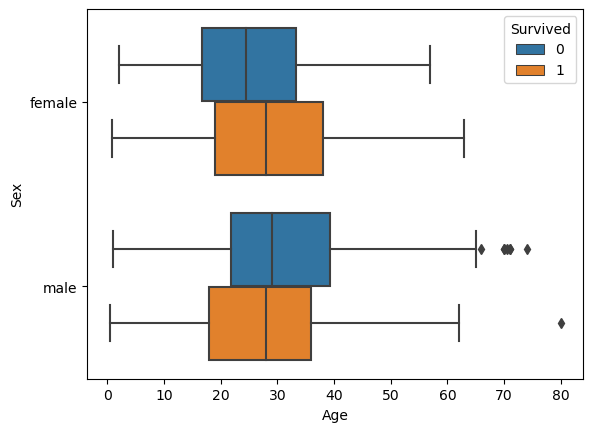

In [13]:
sns.boxplot(data=train, x='Age', y='Sex', hue='Survived');

The results are perhaps starkest when grouping by class: here we really see age distributions of survivors vs. non-survivors diverging.

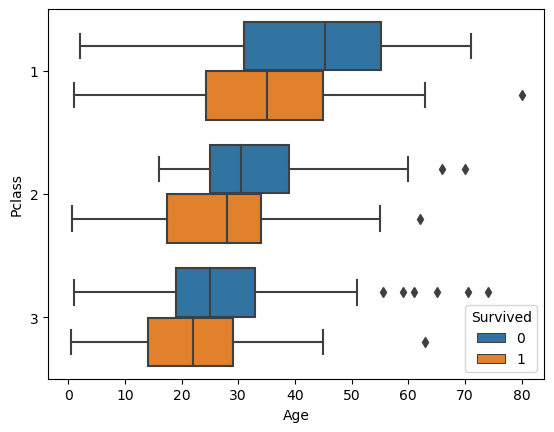

In [14]:
sns.boxplot(data=train, x='Age', y='Pclass', hue='Survived');

This suggests to me that it might be worthwhile to create new features that combine age with each of these categories in hopes of emphasizing these differences.

### Name

On its face, names shouldn't really matter. But out of curiosity, let's take a look. I'm wondering if the length of a passenger's name, both by characters and by component names, correlates meaningfully with survival rates. Perhaps name length could be another proxy for class--at least this is my hypothesis.

In [15]:
# Create new features based on the length of passenger names
train['Name_chars'] = train['Name'].str.replace(',', '').str.len()
train['Name_words'] = train['Name'].str.replace(',', '').str.split().str.len()
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_chars,Name_words
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,50,7
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,21,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,43,7
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,23,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,20,3
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,27,4
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,39,5
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,20,4


What's interesting is that name length in terms of characters actually does seem to correlate with survival rates: passengers with longer names seem to have survived more often!

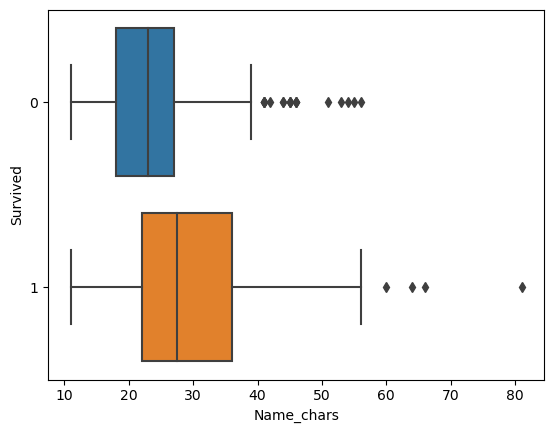

In [16]:
sns.boxplot(data=train, x='Name_chars', y='Survived');

The effect is similar, though less dramatic, when name length is measured by the number of component parts in a passenger's name:

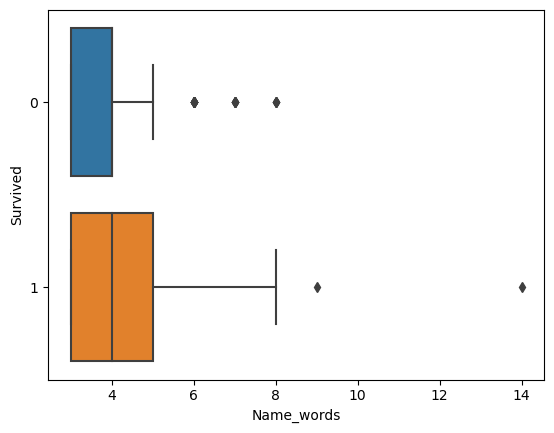

In [17]:
sns.boxplot(data=train, x='Name_words', y='Survived');

## Rerunning Models with Name Feature

In [18]:
X['name_chars'] = train['Name_chars']
X['name_wds'] = train['Name_words']
X

,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,name_chars,name_wds
0,22.000000,1.0,0.0,7.2500,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,22,4
1,38.000000,1.0,0.0,71.2833,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,50,7
2,26.000000,0.0,0.0,7.9250,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,21,3
3,35.000000,1.0,0.0,53.1000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,43,7
4,35.000000,0.0,0.0,8.0500,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,23,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.000000,0.0,0.0,13.0000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,20,3
887,19.000000,0.0,0.0,30.0000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,27,4
888,20.407866,1.0,2.0,23.4500,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,39,5
889,26.000000,0.0,0.0,30.0000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,20,4


In [19]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X, y, random_state=1)

for model in models:
    print(get_score(model, X_train2, X_val2, y_train2, y_val2))

0.8026905829596412
0.7937219730941704
0.7847533632286996
0.7533632286995515
0.7668161434977578


Interestingly, there is a slight improvement here for the simpler models. The more complicated models, however, seem to be overfit, since the performance deteriorates with deeper trees.

## Add Polynomial Features

Since there seem to be interesting interactions between categories—for instance, the age distributions of survivors vs. non-survivors isn't that different on its own, but grouping age with class or port of embarkation or gender does draw out substantial differences—I'll see if adding polynomial features will augment these differences meaningfully.

In [20]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_poly = poly.fit_transform(X)

In [21]:
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_poly, y, random_state=1)

# Create new/simpler models to use

new_models = [
    RandomForestClassifier(random_state=1, max_depth=2, n_estimators=20),
    RandomForestClassifier(random_state=1, max_depth=2, n_estimators=200),
    RandomForestClassifier(random_state=1, max_depth=3, n_estimators=20),
    RandomForestClassifier(random_state=1, max_depth=3, n_estimators=200),
    RandomForestClassifier(random_state=1, max_depth=4, n_estimators=20),
    RandomForestClassifier(random_state=1, max_depth=4, n_estimators=200)
]


for model in new_models:
    print(get_score(model, X_train3, X_val3, y_train3, y_val3))

0.7892376681614349
0.7937219730941704
0.7982062780269058
0.7982062780269058
0.8071748878923767
0.7982062780269058


This is a slightly better performance that my previous model, so I'll see how it performs on the test set.

## Preparing the Test Set

In [22]:
# Create new test dataframe with features I want to use
X_test = test[features]

# One hot encode categorical features
X_test = pd.get_dummies(X_test, columns=['Embarked', 'Pclass', 'Sex'])

# Imput missing `Fare` value using simple imputer
imp_med = SimpleImputer(strategy='median')
X_test['Fare'] = imp_med.fit_transform(X_test[['Fare']])

# Impute missing `Age` values using iterative imputer
imp_iter = IterativeImputer(min_value=X['Age'].min(), max_value=X['Age'].max())
cols = X_test.columns
X_test = pd.DataFrame(imp_iter.fit_transform(X_test))
X_test.columns = cols

# Create new features based on the length of passenger names
X_test['Name_chars'] = test['Name'].str.replace(',', '').str.len()
X_test['Name_words'] = test['Name'].str.replace(',', '').str.split().str.len()

# Add polynomial features
X_test = poly.fit_transform(X_test)

# Create model
model = RandomForestClassifier(random_state=1, max_depth=3, n_estimators=200)

# Fit model on full training set
model.fit(X_poly, y)

# Predict
y_test = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': y_test})
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [23]:
output.to_csv('submissions/submission03.csv', index=False)